# Topic Modeling and visualization on news groups

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [6]:
import pandas as pd
import re
import gensim
import sys
import pprint
sys.path.insert(0, '../helper_functions/')
from nlp_preprocessing import (clean_string_fields)
from nltk import word_tokenize

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'comp.windows.x']) , :]

In [3]:
df['content'] = df['content'].apply(clean_string_fields)

In [7]:
def preprocess_gensim_dictionary(df, series):
    
    corpus=[]
    
    for item in df[series].dropna():
        words=[w for w in word_tokenize(item)]
    
        corpus.append(words)
        
    return corpus

In [8]:
data_words = preprocess_gensim_dictionary(df, series='content')

In [9]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_words)

id2word.filter_extremes(no_below=15, #  Keep tokens contained in at least `no_below` docs
                        no_above=0.2, # Keep tokens contained in no more than `no_above` docs
                        keep_n=10000) # Keep only first `keep_n` most frequent tokens.

# Create Corpus: Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint.pprint(lda_model.print_topics())

[(0,
  '0.023*"team" + 0.020*"hockey" + 0.014*"year" + 0.013*"game" + 0.012*"nhl" + '
  '0.010*"win" + 0.009*"wings" + 0.009*"play" + 0.008*"games" + 0.007*"cup"'),
 (1,
  '0.016*"god" + 0.007*"reason" + 0.007*"evidence" + 0.006*"may" + '
  '0.006*"believe" + 0.005*"jesus" + 0.005*"good" + 0.004*"things" + '
  '0.004*"made" + 0.004*"christians"'),
 (2,
  '0.010*"window" + 0.009*"program" + 0.009*"motif" + 0.009*"use" + '
  '0.007*"entry" + 0.007*"line" + 0.007*"thanks" + 0.007*"server" + '
  '0.006*"using" + 0.006*"set"'),
 (3,
  '0.024*"israel" + 0.015*"israeli" + 0.012*"turkish" + 0.009*"turks" + '
  '0.008*"jews" + 0.008*"greek" + 0.008*"government" + 0.007*"turkey" + '
  '0.007*"said" + 0.007*"war"')]


### Dominant topic and its percentage contribution in each document

In [10]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)

In [11]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, 
                                                  corpus=bow_corpus, 
                                                  texts=data_words)

In [12]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9329,"window, program, motif, use, entry, line, than...","[ann, marie, barden, terminal, config, file, q..."
1,1,0.0,0.7492,"team, hockey, year, game, nhl, win, wings, pla...","[gary, leung, nhl, team, captains, organizatio..."
2,2,1.0,0.8171,"god, reason, evidence, may, believe, jesus, go...","[jonathan, hayward, pantheism, environmentalis..."
3,3,3.0,0.5672,"israel, israeli, turkish, turks, jews, greek, ...","[amir, rosenblatt, israeli, expansion, lust, n..."
4,4,0.0,0.6099,"team, hockey, year, game, nhl, win, wings, pla...","[deepak, chhabra, goalie, masks, nntp, posting..."
5,5,2.0,0.8906,"window, program, motif, use, entry, line, than...","[john, collins, problem, mit, shm, organizatio..."
6,6,1.0,0.9276,"god, reason, evidence, may, believe, jesus, go...","[darius, lecointe, sabbath, admissions, organi..."
7,7,3.0,0.6560,"israel, israeli, turkish, turks, jews, greek, ...","[serdar, argic, day, night, armenians, roundin..."
8,8,0.0,0.6536,"team, hockey, year, game, nhl, win, wings, pla...","[david, jaracz, octopus, detroit, organization..."
9,9,2.0,0.8595,"window, program, motif, use, entry, line, than...","[bill, poitras, automated, testing, reply, org..."


### Frequency Distribution of Word Counts in Documents

In [13]:
doc_lengths = [len(w) for w in df_dominant_topic.Text]
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize = (12,5))
_ = ax.hist(x=doc_lengths, bins=500, range=(0,1000))
_ = plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))

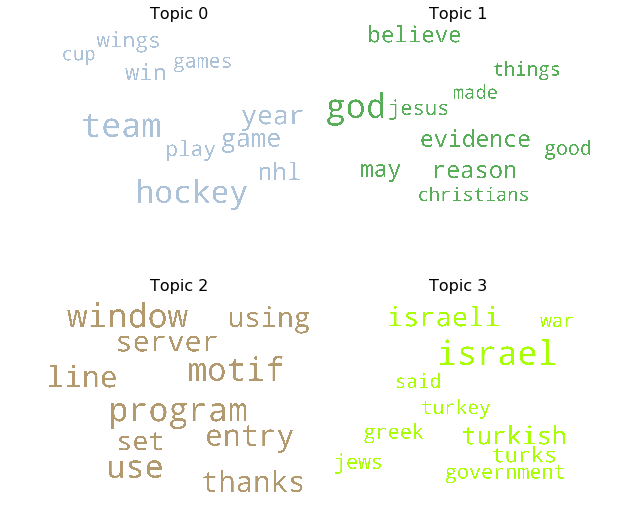

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords

stopwords_en = set(stopwords.words("english"))

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  

cloud = WordCloud(stopwords=stopwords_en,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

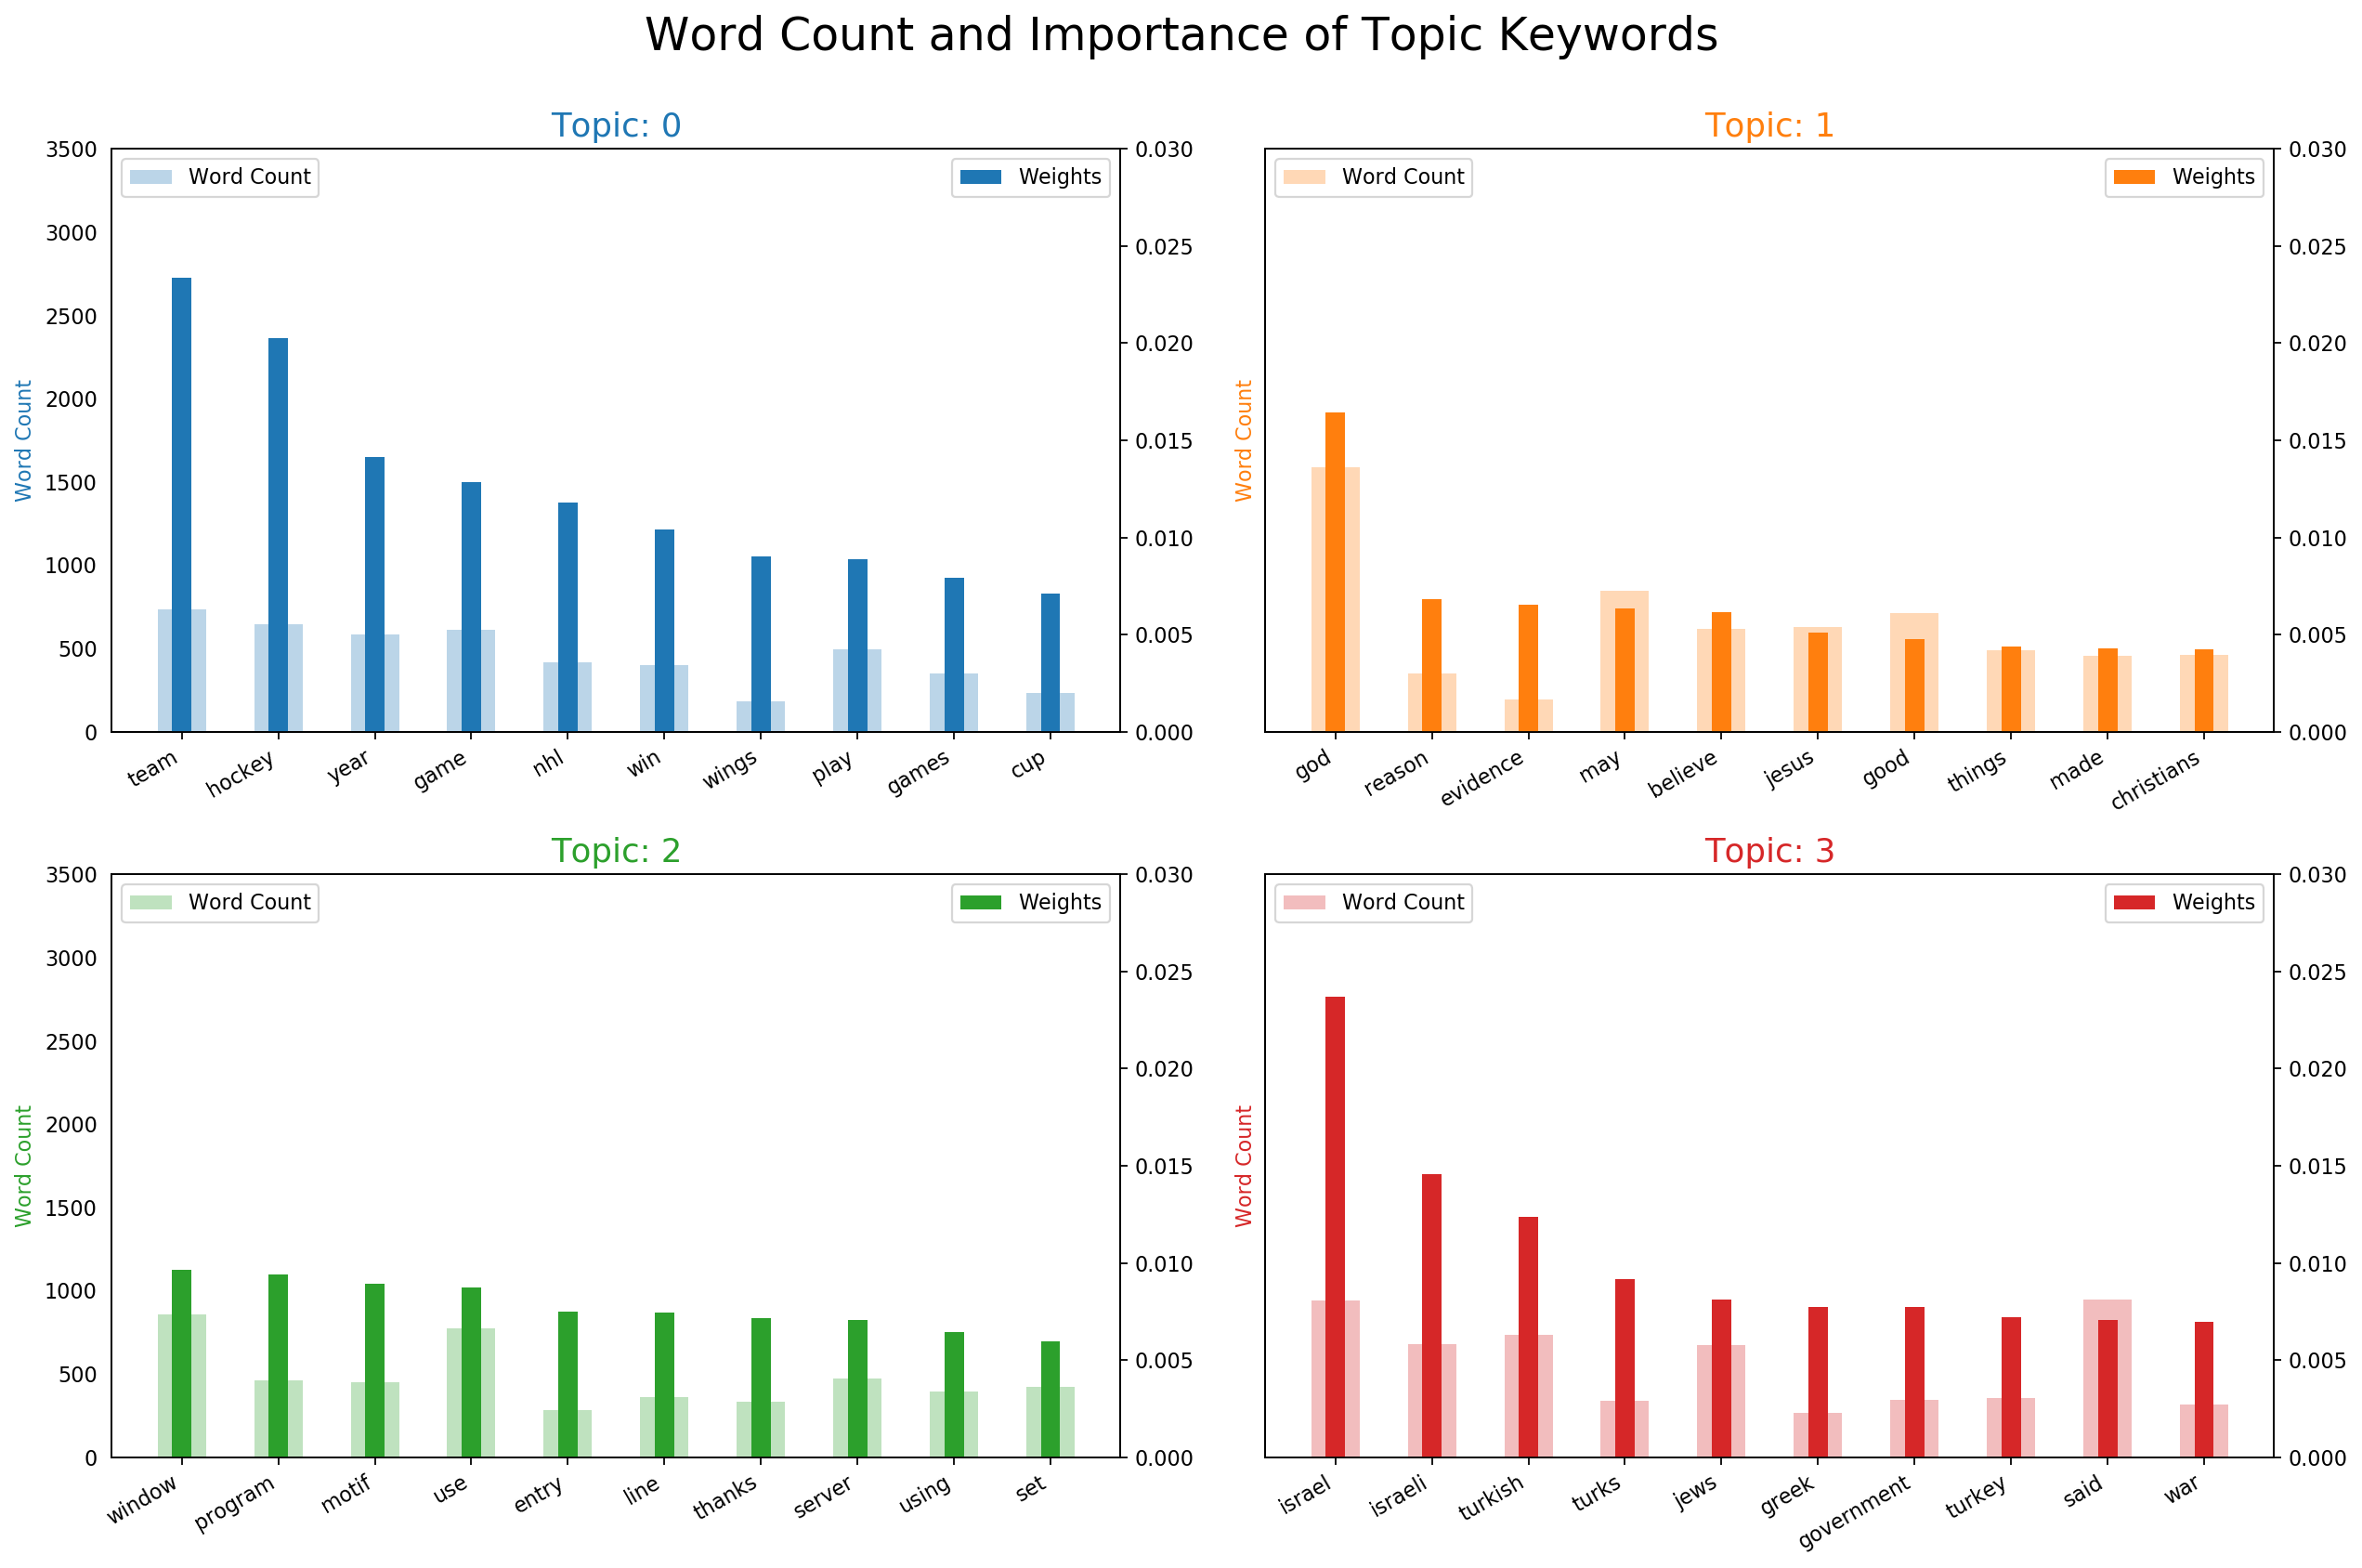

In [17]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

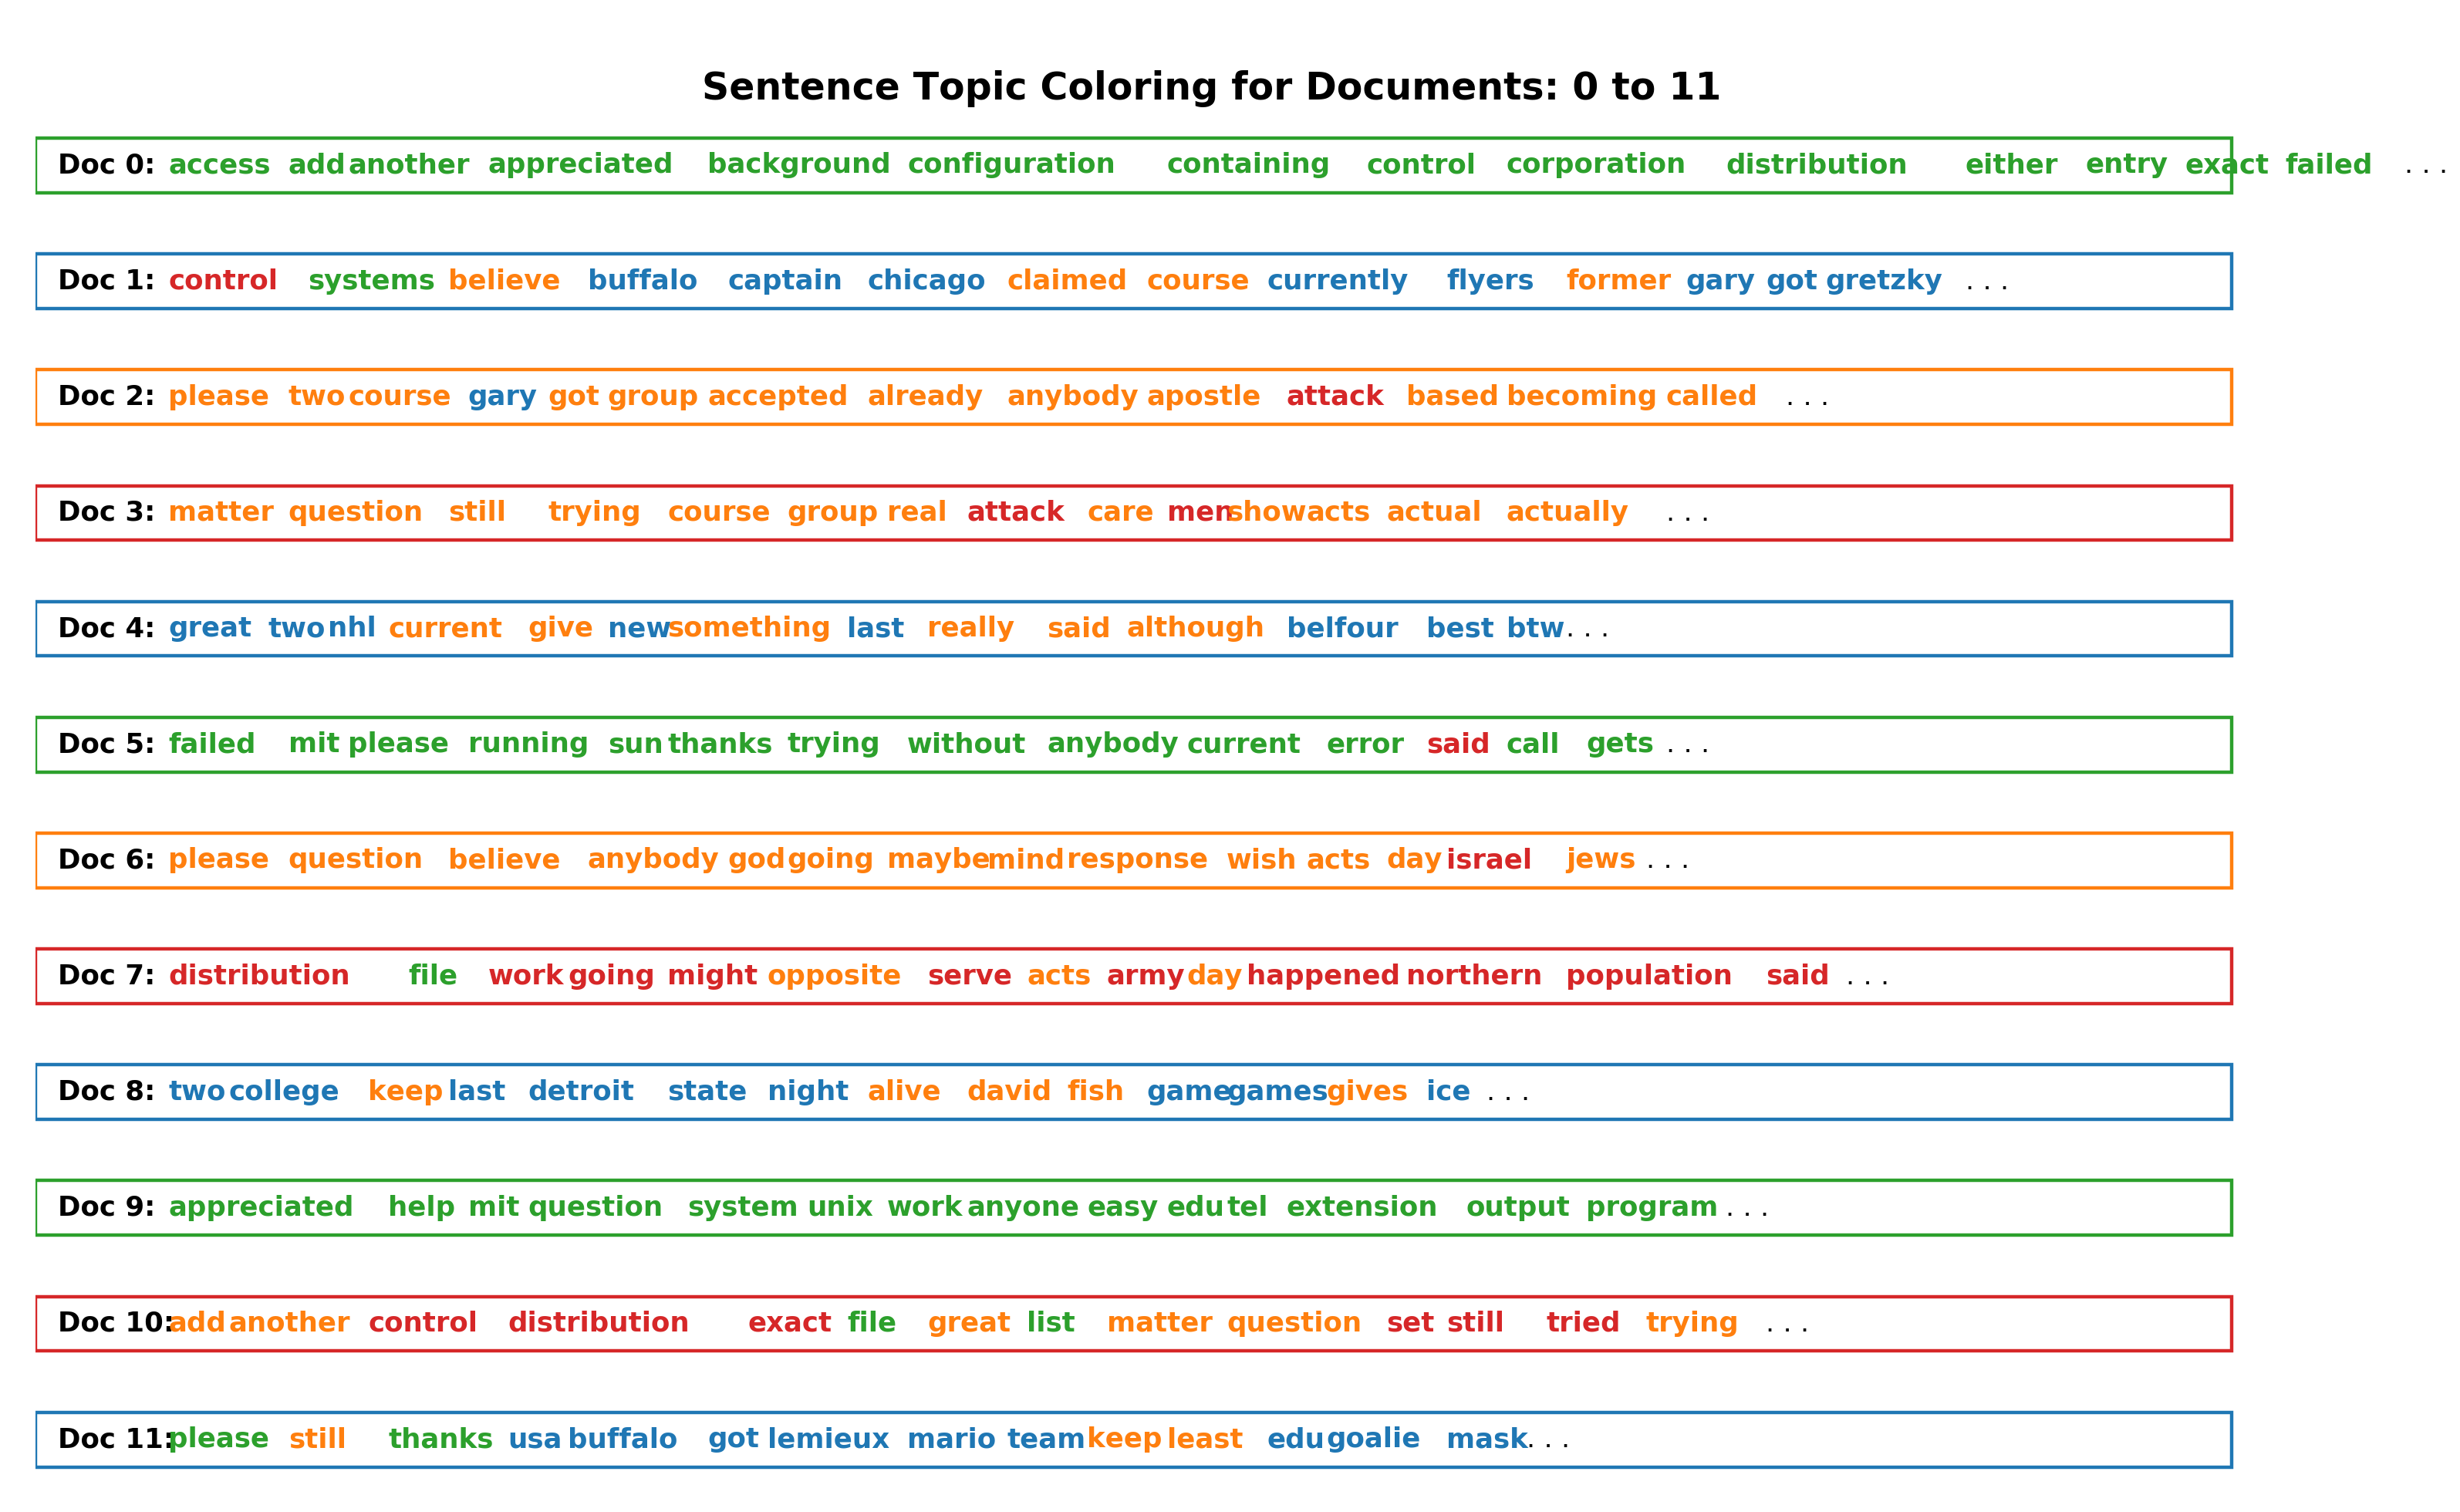

In [18]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start = 0, end = 13):
    
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end - start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model=lda_model, corpus=bow_corpus)    

### t-SNE Clustering Chart

In [20]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
import numpy as np
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2348 samples in 0.001s...
[t-SNE] Computed neighbors for 2348 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2348
[t-SNE] Computed conditional probabilities for sample 2000 / 2348
[t-SNE] Computed conditional probabilities for sample 2348 / 2348
[t-SNE] Mean sigma: 0.028153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.519379
[t-SNE] KL divergence after 1000 iterations: 0.525452


Loading BokehJS ...

In [126]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/home/dmeijerink/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.152973  0.047187       1        1  43.615780
2      0.227763  0.077804       2        1  21.210196
3     -0.099478 -0.330585       3        1  19.559389
0     -0.281259  0.205594       4        1  15.614634, topic_info=     Category         Freq     Term        Total  loglift  logprob
218   Default  1324.000000   israel  1324.000000  30.0000  30.0000
80    Default  1042.000000     team  1042.000000  29.0000  29.0000
112   Default  2043.000000      god  2043.000000  28.0000  28.0000
1429  Default   904.000000   hockey   904.000000  27.0000  27.0000
219   Default   813.000000  israeli   813.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
321    Topic4   629.864258     year   759.546204   1.6697  -4.2591
808    Topic4   246.783676     next   344.520874   1.5233  -5.1961
944    Topic4   196.421860      van   219.066132   1.7479  -5.4243
136    Topic4   309.347260      new   950.861328   0.7341  -4.9701
228    Topic4   220.117020     last   547.466492   0.9458  -5.3104

[197 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1105      3  0.823370  american
1105      4  0.171993  american
2         1  0.862672   another
2         2  0.095115   another
2         4  0.042028   another
...     ...       ...       ...
1459      2  0.996207     xterm
321       3  0.169838      year
321       4  0.829443      year
965       1  0.555045     years
965       3  0.444411     years

[232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])